In [1]:
# Importing import libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# If you need version parsing, use:
from packaging.version import parse as parse_version




In [2]:
# Renaming columns for better readability
columns = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
    'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
    'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
    'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
    'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
    'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label'
]

# Importing the both datasets of UNSW-NB15
# Dataset: UNSW-NB15
df1= pd.read_csv('../Data/UNSW-NB15_1.csv',names=columns, skiprows=1, low_memory=False)
df2= pd.read_csv('../Data/UNSW-NB15_2.csv',names=columns, skiprows=1, low_memory=False)

# Concatenating the two datasets into a single DataFrame
df= pd.concat([df1,df2], ignore_index=True)

# Displaying basic information about the DataFrame
df.info()

# Displaying the first few rows of the DataFrame
df.head()

# Checking for missing values in the DataFrame
df.isnull().sum()


# List all the columns in the DataFrame
df.columns.tolist()

# Displaying the unique values in the 'label' column
df['label'].value_counts()


# Dropping unnecessary columns from the DataFrame which are not needed for macine learning
df.drop(columns=['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 49 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   srcip             1400000 non-null  object 
 1   sport             1400000 non-null  object 
 2   dstip             1400000 non-null  object 
 3   dsport            1400000 non-null  object 
 4   proto             1400000 non-null  object 
 5   state             1400000 non-null  object 
 6   dur               1400000 non-null  float64
 7   sbytes            1400000 non-null  int64  
 8   dbytes            1400000 non-null  int64  
 9   sttl              1400000 non-null  int64  
 10  dttl              1400000 non-null  int64  
 11  sloss             1400000 non-null  int64  
 12  dloss             1400000 non-null  int64  
 13  service           1400000 non-null  object 
 14  Sload             1400000 non-null  float64
 15  Dload             1400000 non-null  float64
 16  

In [3]:
from sklearn.preprocessing import LabelEncoder

# Columns with string values that need to be encoded
cat_columns = ['proto', 'service', 'state']

# Creating ecoder object
label_encoders={}           
              
for col in cat_columns:
    le=LabelEncoder()
    df[col]=le.fit_transform(df[col])
    label_encoders[col] = le # Storing the encoder for later use
    
# Confirming that all values are now numeric
df.dtypes.value_counts()

# Checking class balance
df['label'].value_counts(normalize=True)

# Check for missing values
print("Missing values:", df.isnull().sum().sum())

# Confirm dataset shape
print("Shape of dataset:", df.shape)



Missing values: 592294
Shape of dataset: (1400000, 44)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
# Split into features and target
X = df.drop(columns=['label'])
y = df['label']

# Convert 'ct_ftp_cmd' to numeric and fix spaces (BEFORE splitting)
X['ct_ftp_cmd'] = pd.to_numeric(X['ct_ftp_cmd'].replace(' ', np.nan), errors='coerce')

# Fill NaNs with median (for all numeric columns)
X = X.fillna(X.median(numeric_only=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for any remaining NaNs (should be 0 now)
print("✅ NaNs in X_train:", X_train.isnull().sum().sum())
print("✅ NaNs in X_test:", X_test.isnull().sum().sum())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

print("✅ Model trained successfully on balanced data.")

KeyboardInterrupt: 

In [ ]:
# Model training and evaluation

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Create the model with class_weights ='balanced' to handle any imbalance
rf= RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Step 2: Training the model
rf.fit(X_train, y_train)

# Step 3: Making predictions on the test set
y_pred=rf.predict(X_test)

#Step 4: Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[264542    366]
 [   408  14684]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    264908
           1       0.98      0.97      0.97     15092

    accuracy                           1.00    280000
   macro avg       0.99      0.99      0.99    280000
weighted avg       1.00      1.00      1.00    280000



Training set label distribution:
 label
0    1060128
1      59872
Name: count, dtype: int64


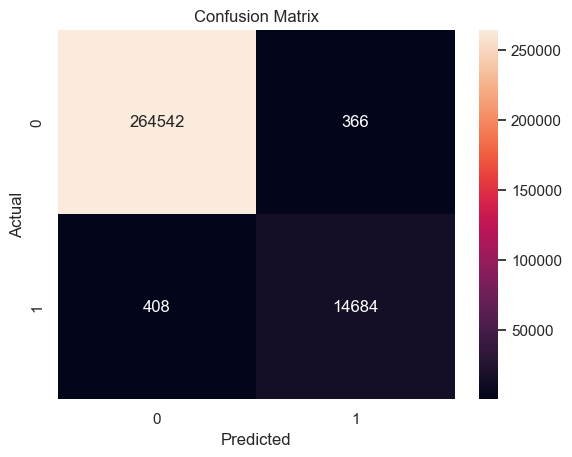

In [ ]:
# Check class balance
print("Training set label distribution:\n", y_train.value_counts())

# Check confusion matrix again
y_pred = rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
